# Analysis of NTSP Development Duration

#### The purpose of this model is to determine whether any features can accurately predict the length of development time of an NTSP.  Development time is measured by Start_Date and Complete_Date (transformed into a time duration).  NTSPs are identified by NTSP_No.

#### Features from other datasets that need to be merged with the original "NTSP" dataframe include:

##### From sponsors1.csv:
    ##### Sponsor name
    ##### Sponsor's organization
    ##### Sponsor's status (A,B,C)
    
##### From cmatt-ntsp3.csv:
    ##### ACAT designation
    ##### organization (PMW/PEO etc)
    ##### Fiscal year started (i.e. is the process getting more or less efficient over time?)

## Bringing in Data

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics

plt.style.use('fivethirtyeight')

%matplotlib inline

#### Read in data from WF-Review-log tab to get NTSP number, time duration of NTSP dev process, version, and status

In [6]:
ntsp=pd.read_csv('WF-review-log.csv')

In [7]:
ntsp.columns

Index([u'REVIEW_ID', u'NTSP_NO', u'TIME_STAMP', u'VERSION', u'STATUS'], dtype='object')

In [8]:
ntsp.shape

(2635, 5)

In [9]:
ntsp.head(10)

,REVIEW_ID,NTSP_NO,TIME_STAMP,VERSION,STATUS
0,16034,N2N6-NTSP-E-70-0013,2013/07/24 10:25:35,6,IN_EDIT
1,16034,N2N6-NTSP-E-70-0013,2013/07/24 10:25:45,6,IN_EDIT
2,13354,N2N6-NTSP-E-70-1103,2013/07/24 10:50:04,2,ACCEPTED
3,16036,N2N6-NTSP-E-70-1103,2013/07/24 10:50:14,11,IN_REVIEW
4,13354,N2N6-NTSP-E-70-1103,2013/07/24 10:50:15,2,ACCEPTED
5,16037,N2N6-NTSP-E-70-1103,2013/07/24 10:50:21,11,IN_REVIEW
6,16034,N2N6-NTSP-E-70-0013,2013/07/24 12:31:35,6,IN_REVIEW
7,16034,N2N6-NTSP-E-70-0013,2013/07/24 12:40:59,6,IN_REVIEW
8,13114,N6-NTSP-E-70-0701A,2013/07/24 12:51:08,2,ACCEPTED
9,15774,N95-NTSP-F-80-1207,2013/07/24 13:49:55,7,ACCEPTED


In [10]:
ntsp.dtypes


REVIEW_ID      int64
NTSP_NO       object
TIME_STAMP    object
VERSION        int64
STATUS        object
dtype: object

In [11]:
ntsp.rename(columns={'REVIEW_ID':'review_id', 'NTSP_NO':'ntsp_no','TIME_STAMP':'time_stamp','VERSION':'version','STATUS':'status'},inplace=True)

In [12]:
ntsp.columns

Index([u'review_id', u'ntsp_no', u'time_stamp', u'version', u'status'], dtype='object')

#### Get count of actual NTSPs in the database currently.

In [13]:
ntspcount = ntsp.groupby(['ntsp_no']).agg('count')
ntspcount
ntspcount.shape

(260, 4)

## Lots of Data Cleaning

#### Drop any NTSP observations with status of 'CANCELLED'.  

In [14]:
ntsp[ntsp.status=="CANCELLED"].head(10)

,review_id,ntsp_no,time_stamp,version,status
41,11246,N85-NTSP-E-70-1003,2013/08/08 08:01:03,6,CANCELLED
52,8488,N6-NTSP-E-70-0006A,2013/08/13 13:58:26,6,CANCELLED
56,11619,N6-NTSP-E-70-0802A,2013/08/13 14:12:53,6,CANCELLED
60,8486,N6-NTSP-E-70-8601E,2013/08/13 14:20:07,6,CANCELLED
64,11609,N6-NTSP-E-70-9501C,2013/08/13 14:26:23,6,CANCELLED
68,21861,N6-NTSP-E-70-9806B,2013/08/13 14:31:49,6,CANCELLED
72,11611,N6-NTSP-E-70-9301C,2013/08/13 14:41:52,6,CANCELLED
80,8430,N6-NTSP-E-70-9906A,2013/08/15 14:57:54,6,CANCELLED
81,11683,N6-NTSP-E-70-0808A,2013/08/15 14:58:18,6,CANCELLED
82,11679,N6-NTSP-E-70-7905G,2013/08/15 14:58:36,6,CANCELLED


In [15]:
ntsp[ntsp.ntsp_no=="N6-NTSP-E-70-7905G"]

,review_id,ntsp_no,time_stamp,version,status
82,11679,N6-NTSP-E-70-7905G,2013/08/15 14:58:36,6,CANCELLED


In [16]:
ntsp=ntsp[ntsp.status!='CANCELLED']

In [17]:
ntsp[ntsp.ntsp_no=="N6-NTSP-E-70-7905G"]


,review_id,ntsp_no,time_stamp,version,status


#### Drop NTSPs that contain 'TEST' or 'test' in the name--these are test/dummy NTSPs

In [18]:
ntsp = ntsp[~ntsp.ntsp_no.str.contains('TEST', na = False, case = False)]
ntsp.head()

,review_id,ntsp_no,time_stamp,version,status
0,16034,N2N6-NTSP-E-70-0013,2013/07/24 10:25:35,6,IN_EDIT
1,16034,N2N6-NTSP-E-70-0013,2013/07/24 10:25:45,6,IN_EDIT
2,13354,N2N6-NTSP-E-70-1103,2013/07/24 10:50:04,2,ACCEPTED
3,16036,N2N6-NTSP-E-70-1103,2013/07/24 10:50:14,11,IN_REVIEW
4,13354,N2N6-NTSP-E-70-1103,2013/07/24 10:50:15,2,ACCEPTED


In [19]:
ntspcount = ntsp.groupby(['ntsp_no']).agg('count')
ntspcount.shape

(211, 4)

#### Reformat 'time_stamp' variable into datetime64 format so we can sort and convert

In [20]:
ntsp.status.value_counts()

ACCEPTED            964
IN_REVIEW           860
IN_EDIT             409
PENDING_COMPLETE    135
SUPERCEDED           52
Name: status, dtype: int64

In [21]:
ntsp.dtypes

review_id      int64
ntsp_no       object
time_stamp    object
version        int64
status        object
dtype: object

In [22]:
ntsp['time_stamp'] = pd.to_datetime(ntsp['time_stamp'], format = "%Y/%m/%d")


In [23]:
ntsp.dtypes

review_id              int64
ntsp_no               object
time_stamp    datetime64[ns]
version                int64
status                object
dtype: object

#### Assign names to version #s so everyone can better understand NTSP workflow progression 

In [24]:
ntsp.version.value_counts()

11    402
2     399
6     379
0     377
1     177
7     165
5     129
4     119
3     106
9      92
8      75
Name: version, dtype: int64

In [25]:
versionDict = {7: "TRP Implementation", 
               8:  "Preliminary NTSP QA",
               9: "Preliminary NTSP Validation",
               3: "NTSP Development",
               4: "NTSP QA",
               0: "Requirements Validation",
               6: "Concurrence Validation",
               1: "N1 Concurrence",
               5: "Resource Sponsor Approval",
               2: "Approved",
               11: "Annual Review",
               12: "Superseded",
               100: "Archived"}

In [26]:
ntsp['WFstep'] = ntsp.version.apply(lambda x: versionDict[x])
ntsp.head()

,review_id,ntsp_no,time_stamp,version,status,WFstep
0,16034,N2N6-NTSP-E-70-0013,2013-07-24 10:25:35,6,IN_EDIT,Concurrence Validation
1,16034,N2N6-NTSP-E-70-0013,2013-07-24 10:25:45,6,IN_EDIT,Concurrence Validation
2,13354,N2N6-NTSP-E-70-1103,2013-07-24 10:50:04,2,ACCEPTED,Approved
3,16036,N2N6-NTSP-E-70-1103,2013-07-24 10:50:14,11,IN_REVIEW,Annual Review
4,13354,N2N6-NTSP-E-70-1103,2013-07-24 10:50:15,2,ACCEPTED,Approved


####  Look at list of WF steps each NTSP went through.  Need this for analysis in the future, probably not for this assignment.

In [27]:
#list(set(ntsp.WFstep.values))

In [28]:
ntspWFperdoc = ntsp.groupby(['ntsp_no']).WFstep.agg(lambda x: ', '.join(set(x))).reset_index()
ntspWFperdoc.head(10)

,ntsp_no,WFstep
0,AA-NTSP-P-80-1604,"NTSP QA, Concurrence Validation, Requirements ..."
1,AA-NTSP-P-80-1605,TRP Implementation
2,AA-NTSP-P-80-1606,"N1 Concurrence, TRP Implementation, Concurrenc..."
3,G-TSCMIS-TSP-E-70-1308,"Approved, Annual Review"
4,N04-NTSP-S-40-0301A,"Approved, Annual Review"
5,N093-NTSP-E-70-1304,"Concurrence Validation, Requirements Validatio..."
6,N09I-NTSP-E-70-1203,"Annual Review, Concurrence Validation, Require..."
7,N1-NTSP-E-80-0901E,"N1 Concurrence, Concurrence Validation, Resour..."
8,N10-NTSP-P-80-1607,TRP Implementation
9,N10-NTSP-P-80-1608,"TRP Implementation, N1 Concurrence"


#### Find StartDate and EndDate for ntsp_no

In [29]:
reviewDateMinDateMax = ntsp.groupby(['ntsp_no']).time_stamp.agg([np.min,np.max])
reviewDateMinDateMax.rename(columns={'amin': 'StartDate', 'amax': 'EndDate'}, inplace = True)
reviewDateMinDateMax = reviewDateMinDateMax.reset_index()
reviewDateMinDateMax.head()

,ntsp_no,StartDate,EndDate
0,AA-NTSP-P-80-1604,2016-02-09 14:22:57,2017-01-05 10:17:24
1,AA-NTSP-P-80-1605,2016-02-25 14:01:11,2016-02-25 14:01:11
2,AA-NTSP-P-80-1606,2016-03-02 10:50:27,2016-07-15 11:46:32
3,G-TSCMIS-TSP-E-70-1308,2014-02-26 08:49:23,2017-03-07 11:07:18
4,N04-NTSP-S-40-0301A,2014-04-23 13:55:28,2014-05-12 16:13:58


In [30]:
#pd.merge?
mergedData = pd.merge(reviewDateMinDateMax, ntspWFperdoc, how='outer', on='ntsp_no', sort=False, suffixes=('_x', '_y'), copy=True, indicator=True)
mergedData.head()

,ntsp_no,StartDate,EndDate,WFstep,_merge
0,AA-NTSP-P-80-1604,2016-02-09 14:22:57,2017-01-05 10:17:24,"NTSP QA, Concurrence Validation, Requirements ...",both
1,AA-NTSP-P-80-1605,2016-02-25 14:01:11,2016-02-25 14:01:11,TRP Implementation,both
2,AA-NTSP-P-80-1606,2016-03-02 10:50:27,2016-07-15 11:46:32,"N1 Concurrence, TRP Implementation, Concurrenc...",both
3,G-TSCMIS-TSP-E-70-1308,2014-02-26 08:49:23,2017-03-07 11:07:18,"Approved, Annual Review",both
4,N04-NTSP-S-40-0301A,2014-04-23 13:55:28,2014-05-12 16:13:58,"Approved, Annual Review",both


In [31]:
mergedData._merge.value_counts()

both          211
right_only      0
left_only       0
Name: _merge, dtype: int64

#### Find time difference between the two dataframes

In [32]:
mergedData['ntspduration'] = mergedData['EndDate'] - mergedData['StartDate']
mergedData['ntspduration'] = mergedData.ntspduration.astype('timedelta64[D]')
mergedData.ntspduration.describe()

count     211.000000
mean      551.616114
std       480.847604
min         0.000000
25%         0.000000
50%       590.000000
75%       951.500000
max      1449.000000
Name: ntspduration, dtype: float64

In [33]:
mergedData.dtypes

ntsp_no                 object
StartDate       datetime64[ns]
EndDate         datetime64[ns]
WFstep                  object
_merge                category
ntspduration           float64
dtype: object

In [34]:
#drinks.groupby('continent').beer.agg(['count', 'mean', 'min', 'max'])
mergedData.groupby('ntsp_no').ntspduration.agg(['count','mean'])

,count,mean
ntsp_no,,
AA-NTSP-P-80-1604,1,330.0
AA-NTSP-P-80-1605,1,0.0
AA-NTSP-P-80-1606,1,135.0
G-TSCMIS-TSP-E-70-1308,1,1105.0
N04-NTSP-S-40-0301A,1,19.0
N093-NTSP-E-70-1304,1,719.0
N09I-NTSP-E-70-1203,1,905.0
N1-NTSP-E-80-0901E,1,0.0
N10-NTSP-P-80-1607,1,0.0


In [35]:
mergedData.ntspduration.describe()

count     211.000000
mean      551.616114
std       480.847604
min         0.000000
25%         0.000000
50%       590.000000
75%       951.500000
max      1449.000000
Name: ntspduration, dtype: float64

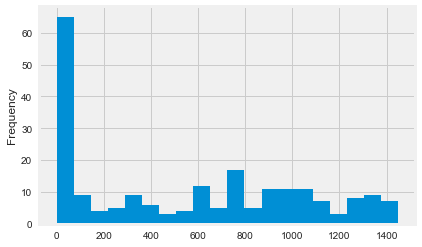

In [36]:
ax = mergedData.ntspduration.plot(kind='hist', bins=20);

#### Drop NTSPs with development duration = 0. 
##### Note: Further cleaning is required here to make sure all documents in dataset went through the same number of workflow steps.  If not, then we need to either delete them or group by number of workflow steps achieved.

In [37]:
mergedData = mergedData[mergedData.ntspduration!=0]
mergedData.ntspduration.describe()

count     157.000000
mean      741.343949
std       411.940494
min        19.000000
25%       381.000000
50%       758.000000
75%      1060.000000
max      1449.000000
Name: ntspduration, dtype: float64

#### New histogram with NTSPs with development duration == 0 dropped

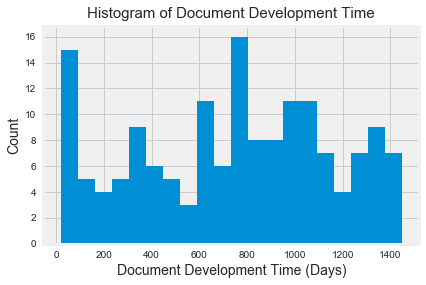

In [38]:
ax = mergedData.ntspduration.plot(kind='hist', bins=20);
ax.set_ylabel('Count', fontsize=14);
ax.set_xlabel('Document Development Time (Days)', fontsize=14);
ax.set_title('Histogram of Document Development Time', fontsize=15, y=1.01);


#### Read in data from Sponsor tab to get sponsors, Sponsor type (User_Status1) , and Organization

In [39]:
sponsors=pd.read_csv('Sponsors1.csv')
sponsors.columns
#notcolumns=['ID','EMAIL','ROLE']

Index([u'NTSP_NO', u'FIRST', u'LAST', u'User_Status1', u'DELETED'], dtype='object')

In [40]:
sponsors.shape

(321, 5)

In [41]:
sponsors.rename(columns={'NTSP_NO':'ntsp_no','FIRST':'firstName','LAST':'lastName','ORGANIZATION':'organization','USER_STATUS':'user_status','DELETED':'deleted'}, inplace=True)


In [42]:
sponsors.head()

,ntsp_no,firstName,lastName,User_Status1,deleted
0,434-NTSP-X-00-TEST,David,Bowie,B,N
1,N04-NTSP-S-40-0301,mark,Washington,C,Y
2,N04-NTSP-S-40-0301A,James,Huey,C,N
3,N093-NTSP-E-70-1304,David,Billings,B,N
4,N096-NTSP-E-80-0101,Don,Hawthorne,B,N


In [43]:
#sponsors.drop(notcolumns, axis=1, inplace=True)
sponsors.columns

Index([u'ntsp_no', u'firstName', u'lastName', u'User_Status1', u'deleted'], dtype='object')

In [44]:
sponsors.head(5)

,ntsp_no,firstName,lastName,User_Status1,deleted
0,434-NTSP-X-00-TEST,David,Bowie,B,N
1,N04-NTSP-S-40-0301,mark,Washington,C,Y
2,N04-NTSP-S-40-0301A,James,Huey,C,N
3,N093-NTSP-E-70-1304,David,Billings,B,N
4,N096-NTSP-E-80-0101,Don,Hawthorne,B,N


In [45]:
sponsors.shape

(321, 5)

## Merging our data (left join/VLookup)

In [46]:
mergedData.shape

(157, 6)

In [47]:
mergedData.head()

,ntsp_no,StartDate,EndDate,WFstep,_merge,ntspduration
0,AA-NTSP-P-80-1604,2016-02-09 14:22:57,2017-01-05 10:17:24,"NTSP QA, Concurrence Validation, Requirements ...",both,330.0
2,AA-NTSP-P-80-1606,2016-03-02 10:50:27,2016-07-15 11:46:32,"N1 Concurrence, TRP Implementation, Concurrenc...",both,135.0
3,G-TSCMIS-TSP-E-70-1308,2014-02-26 08:49:23,2017-03-07 11:07:18,"Approved, Annual Review",both,1105.0
4,N04-NTSP-S-40-0301A,2014-04-23 13:55:28,2014-05-12 16:13:58,"Approved, Annual Review",both,19.0
5,N093-NTSP-E-70-1304,2013-12-20 09:02:29,2015-12-09 10:50:14,"Concurrence Validation, Requirements Validatio...",both,719.0


In [48]:
#drop _merge so we can have _merge available for next merge
mergedData.drop('_merge', axis=1, inplace=True)

#### Second merge:  mergedData with Sponsors1.csv

In [49]:
#pd.merge?
mergdf = pd.merge(mergedData, sponsors, how='left', on='ntsp_no')
mergdf.head()

,ntsp_no,StartDate,EndDate,WFstep,ntspduration,firstName,lastName,User_Status1,deleted
0,AA-NTSP-P-80-1604,2016-02-09 14:22:57,2017-01-05 10:17:24,"NTSP QA, Concurrence Validation, Requirements ...",330.0,NaN,NaN,NaN,NaN
1,AA-NTSP-P-80-1606,2016-03-02 10:50:27,2016-07-15 11:46:32,"N1 Concurrence, TRP Implementation, Concurrenc...",135.0,NaN,NaN,NaN,NaN
2,G-TSCMIS-TSP-E-70-1308,2014-02-26 08:49:23,2017-03-07 11:07:18,"Approved, Annual Review",1105.0,NaN,NaN,NaN,NaN
3,N04-NTSP-S-40-0301A,2014-04-23 13:55:28,2014-05-12 16:13:58,"Approved, Annual Review",19.0,James,Huey,C,N
4,N093-NTSP-E-70-1304,2013-12-20 09:02:29,2015-12-09 10:50:14,"Concurrence Validation, Requirements Validatio...",719.0,David,Billings,B,N


In [50]:
mergdf.shape

(157, 9)

In [51]:
mergedData.shape

(157, 5)

#### Replace sponsor names with "John Doe" and UserStatus1==D if no sponsor name merged

In [52]:
mergdf.lastName.fillna(value='Doe', inplace=True)
mergdf.firstName.fillna(value='John', inplace=True)
mergdf.User_Status1.fillna(value='D', inplace=True)

In [53]:
mergdf

,ntsp_no,StartDate,EndDate,WFstep,ntspduration,firstName,lastName,User_Status1,deleted
0,AA-NTSP-P-80-1604,2016-02-09 14:22:57,2017-01-05 10:17:24,"NTSP QA, Concurrence Validation, Requirements ...",330.0,John,Doe,D,NaN
1,AA-NTSP-P-80-1606,2016-03-02 10:50:27,2016-07-15 11:46:32,"N1 Concurrence, TRP Implementation, Concurrenc...",135.0,John,Doe,D,NaN
2,G-TSCMIS-TSP-E-70-1308,2014-02-26 08:49:23,2017-03-07 11:07:18,"Approved, Annual Review",1105.0,John,Doe,D,NaN
3,N04-NTSP-S-40-0301A,2014-04-23 13:55:28,2014-05-12 16:13:58,"Approved, Annual Review",19.0,James,Huey,C,N
4,N093-NTSP-E-70-1304,2013-12-20 09:02:29,2015-12-09 10:50:14,"Concurrence Validation, Requirements Validatio...",719.0,David,Billings,B,N
5,N09I-NTSP-E-70-1203,2013-08-13 12:04:58,2016-02-04 12:09:35,"Annual Review, Concurrence Validation, Require...",905.0,Mauricio,Adams,B,N
6,N10-NTSP-P-80-1608,2016-05-19 09:09:09,2016-10-05 10:27:59,"TRP Implementation, N1 Concurrence",139.0,John,Doe,D,NaN
7,N16-NTSP-P-80-1701,2017-03-09 13:31:50,2017-06-29 12:21:42,N1 Concurrence,111.0,John,Doe,D,NaN
8,N2N6-NTSP-E-70-0013,2013-07-24 10:25:35,2015-04-23 10:17:10,"N1 Concurrence, Annual Review, Concurrence Val...",637.0,Andrew,Louisville,C,N
9,N2N6-NTSP-E-70-0013A,2015-04-23 10:17:06,2017-06-05 07:28:26,"Preliminary NTSP QA, TRP Implementation, Preli...",773.0,James,Smith,C,N


#### Read in data from CMATT-NTSP tab to get FY started, Community, ACAT, and Organization

In [54]:
commyr=pd.read_csv('CMATT-NTSP3.csv')
commyr.columns


Index([u'NTSP_NO', u'NTSP_ACRONYM', u'VERSION', u'LATEST_COPY', u'FISCAL_YEAR',
       u'TOTAL_SHIP', u'JOINT', u'TOTAL_AIRCRAFT', u'COMMUNITY', u'ACAT',
       u'DA', u'ORGANIZATION', u'NOMENCLATURE'],
      dtype='object')

In [55]:
commyr.COMMUNITY.value_counts()

California        253
Georgia            92
Oklahoma           35
South Dakota       12
Louisiana          10
Arkansas            6
New Hampshire       6
South Carolina      3
Ohio                3
Name: COMMUNITY, dtype: int64

In [56]:
notcolumns=['DA','NOMENCLATURE','NTSP_ACRONYM']
commyr.drop(notcolumns, axis=1, inplace=True)

In [57]:
commyr.rename(columns={'NTSP_NO':'ntsp_no', 'NTSP_ACRONYM':'ntsp_short', 'VERSION':'version', 'LATEST_COPY':'l_copy', 'FISCAL_YEAR':'fy', 'TOTAL_SHIP':'t_ship','JOINT':'joint', 'TOTAL_AIRCRAFT':'t_aircraft', 'COMMUNITY':'comm', 'ACAT':'acat', 'ORGANIZATION':'org'}, inplace=True)
commyr.columns


Index([u'ntsp_no', u'version', u'l_copy', u'fy', u't_ship', u'joint',
       u't_aircraft', u'comm', u'acat', u'org'],
      dtype='object')

#### Third merge (mergdf with commyr data) to merge FY, Community, ACAT, Organization

In [58]:
finaldf = pd.merge(mergdf, commyr, how='left', on='ntsp_no', sort=False, suffixes=('_x', '_y'), copy=True)
finaldf.head(5)


,ntsp_no,StartDate,EndDate,WFstep,ntspduration,firstName,lastName,User_Status1,deleted,version,l_copy,fy,t_ship,joint,t_aircraft,comm,acat,org
0,AA-NTSP-P-80-1604,2016-02-09 14:22:57,2017-01-05 10:17:24,"NTSP QA, Concurrence Validation, Requirements ...",330.0,John,Doe,D,NaN,6,E,2016,N,N,N,Ohio,Yellow,White Sox
1,AA-NTSP-P-80-1606,2016-03-02 10:50:27,2016-07-15 11:46:32,"N1 Concurrence, TRP Implementation, Concurrenc...",135.0,John,Doe,D,NaN,5,R,2016,N,N,N,Oklahoma,NaN,White Sox
2,G-TSCMIS-TSP-E-70-1308,2014-02-26 08:49:23,2017-03-07 11:07:18,"Approved, Annual Review",1105.0,John,Doe,D,NaN,2,Y,2013,N,N,N,Georgia,NaN,Orioles
3,N04-NTSP-S-40-0301A,2014-04-23 13:55:28,2014-05-12 16:13:58,"Approved, Annual Review",19.0,James,Huey,C,N,2,Y,2010,N,N,N,Louisiana,Blue,Ravens
4,N093-NTSP-E-70-1304,2013-12-20 09:02:29,2015-12-09 10:50:14,"Concurrence Validation, Requirements Validatio...",719.0,David,Billings,B,N,5,E,2013,N,N,N,Georgia,NaN,Pirates


In [59]:
finaldf.shape

(157, 18)

In [60]:
finaldf.columns

Index([u'ntsp_no', u'StartDate', u'EndDate', u'WFstep', u'ntspduration',
       u'firstName', u'lastName', u'User_Status1', u'deleted', u'version',
       u'l_copy', u'fy', u't_ship', u'joint', u't_aircraft', u'comm', u'acat',
       u'org'],
      dtype='object')

In [61]:
# it can ruin a model to have unknowns
finaldf = finaldf.fillna(value = 'Unknown')

In [62]:
# Check the 4 features I will use (lastName, org, comm, fy, User_Status1) to see if 'Unknown' filled in any missing data.

In [63]:
finaldf.lastName.value_counts()

Hawthorne      63
Doe            13
Madeye         11
Huey            8
Shoemaker       7
Giddings        7
Collins         5
Hall            4
Smith           3
Moon            3
Longbottom      3
Volkswagon      3
Louisville      3
Longfellow      3
Isle            2
Kim             2
Pullman         2
Sopwith         1
Moore           1
Adams           1
Hempsey         1
Benson          1
Louisiana       1
Williams        1
Brahms          1
Allmon          1
Batman          1
Hemingway       1
Bach            1
Stuyversant     1
Billings        1
Neville         1
Name: lastName, dtype: int64

In [64]:
finaldf.org.value_counts()

Orioles       25
Braves        17
Spurs         15
Falcons       13
Rockies       13
Dodgers       10
Mariners       7
Bengals        7
Cubs           6
Saints         6
White Sox      4
Broncos        4
Cardinals      4
Athletics      2
Chargers       2
Twins          2
Rays           2
Chiefs         2
Padres         2
Steelers       2
Ravens         2
Yankees        1
Cowboys        1
Packers        1
Patriots1      1
Indians        1
Pirates        1
Buccaneers     1
Blue Jays      1
Lions          1
Titans         1
Name: org, dtype: int64

In [65]:
finaldf.comm.value_counts()

California       93
Georgia          30
Oklahoma         20
Louisiana         5
New Hampshire     3
Ohio              2
Arkansas          2
South Dakota      1
Unknown           1
Name: comm, dtype: int64

In [66]:
finaldf.User_Status1.value_counts()

B    80
C    44
A    20
D    13
Name: User_Status1, dtype: int64

In [67]:
finaldf.fy.value_counts().sort_index()

2000     1
2001     3
2002     2
2005     1
2006     1
2007     3
2008     7
2009    14
2010     9
2011    12
2012    23
2013     8
2014    14
2015    18
2016    26
2017    15
Name: fy, dtype: int64

#### Check to see if there are any Total_Ship or Total_Aircraft NTSPs; might be able to combine both into a feature/dummy variable

In [68]:
finaldf.t_ship.value_counts(dropna=False)

N          155
Unknown      1
Y            1
Name: t_ship, dtype: int64

In [69]:
finaldf.t_aircraft.value_counts(dropna=False)
#how to include blank values

N          151
Unknown      6
Name: t_aircraft, dtype: int64

    #### Based on the above, there is probably not enough data to make this into a feature, with only one NTSP that is a t_ship and no t_aircraft identified.

##### Check parent community ('comm') of organizations ('org')

In [70]:
finaldf.groupby(['comm']).org.value_counts()


comm           org       
Arkansas       Orioles        2
California     Braves        16
               Orioles       15
               Rockies       13
               Spurs         12
               Mariners       7
               Bengals        6
               Cubs           6
               Dodgers        5
               Athletics      2
               Broncos        2
               Cardinals      2
               Chiefs         2
               Buccaneers     1
               Indians        1
               Lions          1
               Packers        1
               Rays           1
Georgia        Orioles        6
               Dodgers        4
               Spurs          3
               Cardinals      2
               Chargers       2
               Falcons        2
               Saints         2
               Steelers       2
               Braves         1
               Broncos        1
               Cowboys        1
               Padres         1
              

## Quick visualizations to look at features identified below in feature columns

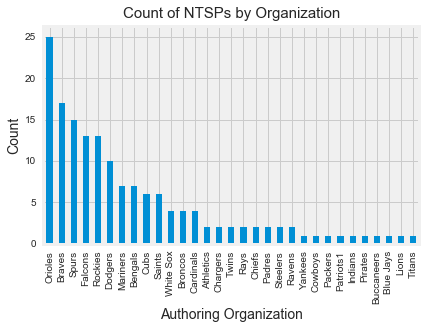

In [71]:
ax = finaldf.org.value_counts().plot(kind='bar');
ax.set_ylabel('Count', fontsize=14);
ax.set_xlabel('Authoring Organization', fontsize=14);
ax.set_title('Count of NTSPs by Organization', fontsize=15, y=1.01);

In [72]:
finaldf.org.value_counts(dropna=False)

Orioles       25
Braves        17
Spurs         15
Falcons       13
Rockies       13
Dodgers       10
Mariners       7
Bengals        7
Cubs           6
Saints         6
White Sox      4
Broncos        4
Cardinals      4
Athletics      2
Chargers       2
Twins          2
Rays           2
Chiefs         2
Padres         2
Steelers       2
Ravens         2
Yankees        1
Cowboys        1
Packers        1
Patriots1      1
Indians        1
Pirates        1
Buccaneers     1
Blue Jays      1
Lions          1
Titans         1
Name: org, dtype: int64

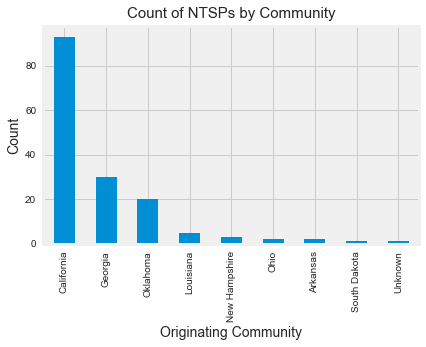

In [73]:
# Get count of NTSPs developed by community
ax = finaldf.comm.value_counts().plot(kind='bar');
ax.set_ylabel('Count', fontsize=14);
ax.set_xlabel('Originating Community', fontsize=14);
ax.set_title('Count of NTSPs by Community', fontsize=15, y=1.01);

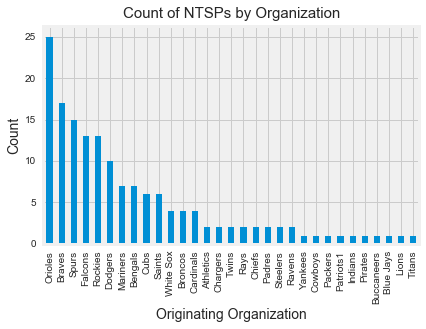

In [74]:
# Get count of NTSPs developed by organization
ax = finaldf.org.value_counts().plot(kind='bar');
ax.set_ylabel('Count', fontsize=14);
ax.set_xlabel('Originating Organization', fontsize=14);
ax.set_title('Count of NTSPs by Organization', fontsize=15, y=1.01);

In [75]:
finaldf.comm.value_counts()

California       93
Georgia          30
Oklahoma         20
Louisiana         5
New Hampshire     3
Ohio              2
Arkansas          2
South Dakota      1
Unknown           1
Name: comm, dtype: int64

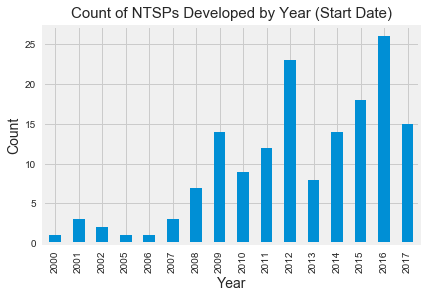

In [76]:
ax = finaldf.fy.value_counts().sort_index().plot(kind='bar');
ax.set_ylabel('Count', fontsize=14);
ax.set_xlabel('Year', fontsize=14);
ax.set_title('Count of NTSPs Developed by Year (Start Date)', fontsize=15, y=1.01);

###### Check distribution of ACAT categories.  This feature has a lot of missing data.  As time allows, I will try to populate NaNs with correct data.  This missing data is due to lack of data validation in the web app--there are too many features that are optional for the user to enter that should be required.  The information is available from other sources; it's just time-consuming to retrieve.


In [77]:
finaldf.acat.value_counts(dropna=False)

Unknown    100
Blue        20
Orange      17
Red         15
Green        4
Yellow       1
Name: acat, dtype: int64

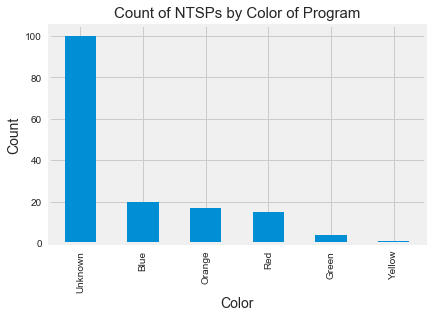

In [78]:
# ACAT/Color Desingation
ax = finaldf.acat.value_counts().plot(kind='bar');
ax.set_ylabel('Count', fontsize=14);
ax.set_xlabel('Color', fontsize=14);
ax.set_title('Count of NTSPs by Color of Program', fontsize=15, y=1.01);

In [79]:
#### Look at average NTSP duration by fiscal year (the document development began)

In [80]:
finaldf.groupby('fy').ntspduration.agg(['count','mean','min', 'max'])

,count,mean,min,max
fy,,,,
2000,1,212.000000,212.0,212.0
2001,3,121.000000,62.0,212.0
2002,2,697.000000,51.0,1343.0
2005,1,261.000000,261.0,261.0
2006,1,62.000000,62.0,62.0
2007,3,214.333333,78.0,476.0
2008,7,758.000000,89.0,1343.0
2009,14,865.357143,516.0,1232.0
2010,9,476.555556,19.0,1330.0


#### Look at average development time by Fiscal Year Initiated.  This needs further cleaning because the dataset includes documents that have not been completed yet.

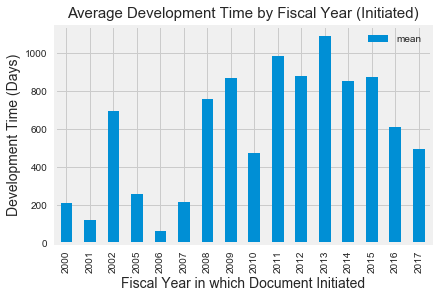

In [81]:
ax = finaldf.groupby('fy').ntspduration.agg(['mean']).plot(kind='bar');
ax.set_ylabel('Development Time (Days)', fontsize=14);
ax.set_xlabel('Fiscal Year in which Document Initiated', fontsize=14);
ax.set_title('Average Development Time by Fiscal Year (Initiated)', fontsize=15, y=1.01);

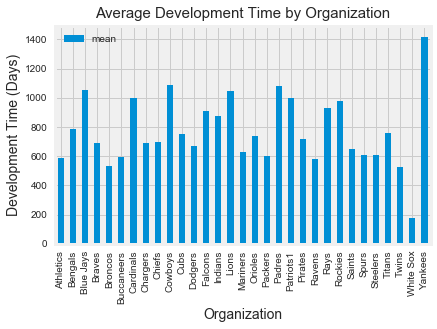

In [82]:
ax = finaldf.groupby('org').ntspduration.agg(['mean']).plot(kind='bar');
ax.set_ylabel('Development Time (Days)', fontsize=14);
ax.set_xlabel('Organization', fontsize=14);
ax.set_title('Average Development Time by Organization', fontsize=15, y=1.01);

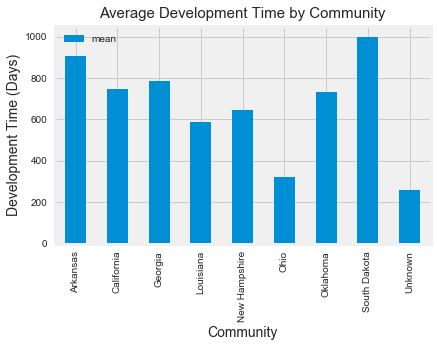

In [83]:
ax = finaldf.groupby('comm').ntspduration.agg(['mean']).plot(kind='bar');
ax.set_ylabel('Development Time (Days)', fontsize=14);
ax.set_xlabel('Community', fontsize=14);
ax.set_title('Average Development Time by Community', fontsize=15, y=1.01);

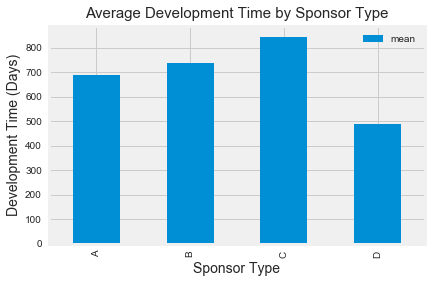

In [84]:
ax = finaldf.groupby('User_Status1').ntspduration.agg(['mean']).plot(kind='bar');
ax.set_ylabel('Development Time (Days)', fontsize=14);
ax.set_xlabel('Sponsor Type', fontsize=14);
ax.set_title('Average Development Time by Sponsor Type', fontsize=15, y=1.01);

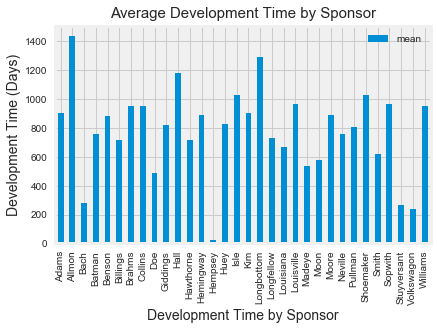

In [85]:
ax = finaldf.groupby('lastName').ntspduration.agg(['mean']).plot(kind='bar');
ax.set_ylabel('Development Time (Days)', fontsize=14);
ax.set_xlabel('Development Time by Sponsor', fontsize=14);
ax.set_title('Average Development Time by Sponsor', fontsize=15, y=1.01);

## Modeling

### Predict ntspduration using linear regression first

In [86]:
# fit_intercept to be false because we know every project takes some time at least
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=False, normalize=True)
type(lr)

sklearn.linear_model.base.LinearRegression

In [87]:
finaldf.columns

Index([u'ntsp_no', u'StartDate', u'EndDate', u'WFstep', u'ntspduration',
       u'firstName', u'lastName', u'User_Status1', u'deleted', u'version',
       u'l_copy', u'fy', u't_ship', u'joint', u't_aircraft', u'comm', u'acat',
       u'org'],
      dtype='object')

In [88]:
#need to add acat once it has been populated.  Leaving out fiscal year (fy) for now also.
feature_cols = ['lastName','comm','org','User_Status1']
X = finaldf[feature_cols]
y = pd.DataFrame(finaldf.ntspduration)

In [89]:
X.columns


Index([u'lastName', u'comm', u'org', u'User_Status1'], dtype='object')

When I tried the linear regression the first time, I got an error saying that it cannot convert string to float.  Consulted with Mike G., the fearless TA, and learned that learner models like logistic regression, distance based methods such as kNN, support vector machines, tree based methods etc. in sklearn need numeric arrays. Features having string values (i.e., all my features for this dataset) cannot be handled by these learners.  So, I need to create dummies for all my categorical variables.

In [90]:
# First categorical variable:  lastName
lastName_dummies = pd.get_dummies(X['lastName'])

# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
X = pd.concat([X, lastName_dummies], axis=1)
X.head()

,lastName,comm,org,User_Status1,Adams,Allmon,Bach,Batman,Benson,Billings,...,Moon,Moore,Neville,Pullman,Shoemaker,Smith,Sopwith,Stuyversant,Volkswagon,Williams
0,Doe,Ohio,White Sox,D,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Doe,Oklahoma,White Sox,D,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Doe,Georgia,Orioles,D,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Huey,Louisiana,Ravens,C,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Billings,Georgia,Pirates,B,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [91]:
#Second categorical variable:  comm
comm_dummies = pd.get_dummies(X['comm'])

# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
X = pd.concat([X, comm_dummies], axis=1)
X.head()

,lastName,comm,org,User_Status1,Adams,Allmon,Bach,Batman,Benson,Billings,...,Williams,Arkansas,California,Georgia,Louisiana,New Hampshire,Ohio,Oklahoma,South Dakota,Unknown
0,Doe,Ohio,White Sox,D,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,Doe,Oklahoma,White Sox,D,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,Doe,Georgia,Orioles,D,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,Huey,Louisiana,Ravens,C,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,Billings,Georgia,Pirates,B,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [92]:
#Third categorical variable:  org
org_dummies = pd.get_dummies(X['org'])

# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
X = pd.concat([X, org_dummies], axis=1)
X.head()

,lastName,comm,org,User_Status1,Adams,Allmon,Bach,Batman,Benson,Billings,...,Ravens,Rays,Rockies,Saints,Spurs,Steelers,Titans,Twins,White Sox,Yankees
0,Doe,Ohio,White Sox,D,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,Doe,Oklahoma,White Sox,D,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,Doe,Georgia,Orioles,D,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Huey,Louisiana,Ravens,C,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,Billings,Georgia,Pirates,B,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [93]:
#Fourth categorical variable:  User_Status1
User_Status1_dummies = pd.get_dummies(X['User_Status1'])

# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
X = pd.concat([X, User_Status1_dummies], axis=1)
X.head()

,lastName,comm,org,User_Status1,Adams,Allmon,Bach,Batman,Benson,Billings,...,Spurs,Steelers,Titans,Twins,White Sox,Yankees,A,B,C,D
0,Doe,Ohio,White Sox,D,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,Doe,Oklahoma,White Sox,D,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,Doe,Georgia,Orioles,D,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Huey,Louisiana,Ravens,C,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,Billings,Georgia,Pirates,B,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [94]:
X.dtypes

lastName        object
comm            object
org             object
User_Status1    object
Adams            uint8
Allmon           uint8
Bach             uint8
Batman           uint8
Benson           uint8
Billings         uint8
Brahms           uint8
Collins          uint8
Doe              uint8
Giddings         uint8
Hall             uint8
Hawthorne        uint8
Hemingway        uint8
Hempsey          uint8
Huey             uint8
Isle             uint8
Kim              uint8
Longbottom       uint8
Longfellow       uint8
Louisiana        uint8
Louisville       uint8
Madeye           uint8
Moon             uint8
Moore            uint8
Neville          uint8
Pullman          uint8
                 ...  
Buccaneers       uint8
Cardinals        uint8
Chargers         uint8
Chiefs           uint8
Cowboys          uint8
Cubs             uint8
Dodgers          uint8
Falcons          uint8
Indians          uint8
Lions            uint8
Mariners         uint8
Orioles          uint8
Packers    

#### Rename X to be just the dummy variables in X so that the algorithms below can work as coded

In [95]:
X=X._get_numeric_data()

In [96]:
y.columns

Index([u'ntspduration'], dtype='object')

In [97]:
y.dtypes

ntspduration    float64
dtype: object

In [98]:
print(type(X))
print(type(X.values))
print(type(y))
print(type(y.values))
print(X.shape)
print(y.shape)

<class 'pandas.core.frame.DataFrame'>
<type 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<type 'numpy.ndarray'>
(157, 76)
(157, 1)


In [99]:
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=True)

In [100]:
y_pred = lr.predict(X)

#print 'y_pred:', y_pred
#y_pred.shape
#type(y_pred)
y_pred=y_pred.reshape(-1)
y_pred.shape
print 'y_pred:', y_pred

y_pred: [  -54.25   254.25   779.75   578.5    720.5    905.     254.25   254.25
   843.5    446.     561.     873.     534.5    649.     925.5    603.5
   586.     586.     649.     649.     554.5    590.25  1086.5    534.5
   898.     920.     666.     889.     649.     925.     649.     673.
  1050.5    649.     935.     649.     649.     242.     649.     649.
  1026.5   1026.5   1043.    1225.     952.    1389.5    733.     898.
    17.25   733.     757.5    267.5   1206.     737.5    950.5    278.
   810.5    570.25   744.    1030.     773.25   588.     561.    1418.
   733.     629.5    949.     564.     595.25   605.     686.     686.
   693.     693.     342.    1225.     957.5    576.     576.     655.5
   881.     885.5    964.     576.     907.     907.     901.5    901.5
   908.5    908.5   1428.     737.     881.     168.     578.5    561.
   461.     873.     949.     949.     873.     649.     235.5    932.5
   554.5    873.     235.5    534.5    949.     840.5   1389.5

In [101]:
d={'y_pred':y_pred, 'y':y['ntspduration']}
df = pd.DataFrame(d)

df.shape

(157, 2)

In [102]:
print(metrics.mean_squared_error(y['ntspduration'], y_pred))

96471.8280255


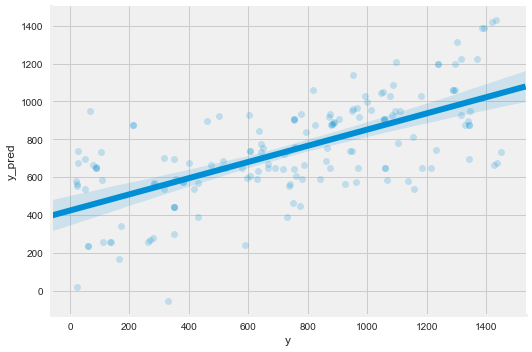

In [103]:
sns.lmplot(x='y', y='y_pred', data=df, aspect=1.5, scatter_kws={'alpha':0.2});

### Try test-train-split algorithm

In [104]:
from sklearn.model_selection import train_test_split
from sklearn import metrics


# fit_intercept to be false because we know every project takes some time at least
#def train_test_rmse(df, feature_cols):
#    X=df[feature_cols]
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)
    
linreg = LinearRegression(fit_intercept=False, normalize=True)
linreg.fit(X_train, y_train)
    
y_pred = linreg.predict(X_test)
#    return np.sqrt(metrics.mean_squared_error(y_test, y_pred)), y_test, y_pred

zip(y_pred, y_test.values)

[(array([ 460.9375]), array([ 1338.])),
 (array([ 585.28125]), array([ 417.])),
 (array([ 437.75]), array([ 349.])),
 (array([ 1103.0625]), array([ 1058.])),
 (array([  3.35576959e+14]), array([ 666.])),
 (array([ 1103.0625]), array([ 754.])),
 (array([ 1058.]), array([ 754.])),
 (array([ 1216.1875]), array([ 1302.])),
 (array([ 761.65625]), array([ 604.])),
 (array([ 933.90625]), array([ 1111.])),
 (array([ 1108.375]), array([ 1289.])),
 (array([ 761.65625]), array([ 949.])),
 (array([ 809.03125]), array([ 25.])),
 (array([ 1393.125]), array([ 1387.])),
 (array([ 1273.125]), array([ 637.])),
 (array([  8.25448959e+14]), array([ 631.])),
 (array([ -3.58992575e+14]), array([ 1045.])),
 (array([ 391.5]), array([ 172.])),
 (array([ 1401.625]), array([ 316.])),
 (array([ 1180.625]), array([ 1078.])),
 (array([ 613.78125]), array([ 524.])),
 (array([ 854.09375]), array([ 24.])),
 (array([ 544.59375]), array([ 1438.])),
 (array([ 613.78125]), array([ 1060.])),
 (array([ 613.78125]), array([ 

In [105]:
np.sqrt(metrics.mean_squared_error(y_test.values, y_pred))

169821003893980.75

In [107]:
#d={'y_pred':y_pred, 'y':y_test['ntspduration']}
#df = pd.DataFrame(d)
#df.shape

In [109]:
#temp_df.plot(kind='scatter', x='y_test', y='y_pred')
#This is not the correct graph yet.
#sns.lmplot(x='y', y='y_pred', data=df, aspect=1.5, scatter_kws={'alpha':0.2});

### Try k-fold cross-validation at k=5

In [110]:
from sklearn import model_selection
kf = model_selection.KFold(n_splits=5, shuffle=True)

mse_values = []
scores = []
n= 0
print "~~~~ CROSS VALIDATION each fold ~~~~"
for train_index, test_index in kf.split(X, y):
    
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    n+=1
    print 'Model', n
    print 'MSE:', mse_values[n-1]
    print 'R2:', scores[n-1]
    
print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
print 'Mean of MSE for all folds:', np.mean(mse_values)
print 'Mean of R2 for all folds:', np.mean(scores)

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 8.98112124839e+29
R2: -1.08564282977e+24
Model 2
MSE: 6.75923710597e+28
R2: -8.17060264068e+22
Model 3
MSE: 6.83884583706e+29
R2: -8.00849554268e+23
Model 4
MSE: 7.02067535273e+28
R2: -8.22142341097e+22
Model 5
MSE: 4.2308830224e+29
R2: -4.95449212247e+23
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 4.28576827075e+29
Mean of R2 for all folds: -5.09172371361e+23


### Try decision tree regressor

In [111]:
# may need to add a max_depth argument at treereg = DecisionTreeRegressor(max_depth=X, random_state=1)
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=46, test_size=0.2)

treereg = DecisionTreeRegressor(max_depth=4, random_state=1)
treereg.fit(X_train,y_train)

print "training error of this decision tree is: ", np.sqrt(metrics.mean_squared_error(y_train, treereg.predict(X_train))) 
print "test error of this decision tree is: ", np.sqrt(metrics.mean_squared_error(y_test, treereg.predict(X_test))) 

training error of this decision tree is:  370.206888859
test error of this decision tree is:  354.715116802


In [112]:
treereg.score(X_test, y_test)

0.14753477518795632

In [113]:
#pd.DataFrame({'feature':X, 'importance':treereg.feature_importances_})

In [114]:
y_test.columns

Index([u'ntspduration'], dtype='object')

In [115]:
d={'y_pred':treereg.predict(X_test), 'y':y_test['ntspduration']}
df = pd.DataFrame(d)
df.shape

(32, 2)

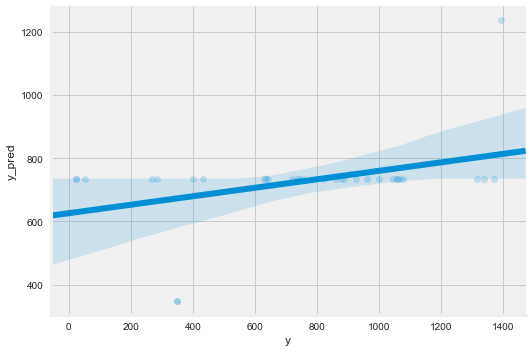

In [116]:
sns.lmplot(x='y', y='y_pred', data=df, aspect=1.5, scatter_kws={'alpha':0.2});

In [ ]:
#Try a tree diagram
from sklearn.tree import export_graphviz
#export_graphviz(treereg, out_file='./treegraphviz.dot', feature_names=X)

#### Try knn regressor

In [117]:
from sklearn.neighbors import KNeighborsRegressor

#### Step 1: Split X and y into training and testing sets (using random_state for reproducibility).

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

#### Step 2: Train the model on the training set (using K=1).

In [119]:
knn = KNeighborsRegressor(n_neighbors=1)
# call instance of algorithm

knn.fit(X_train, y_train)
# fit training data

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=1, p=2,
          weights='uniform')

#### Step 3: Test the model on the testing set and check the accuracy

In [123]:
y_pred_class = knn.predict(X_test)
# predict
testing_accuracy=(metrics.accuracy_score(y_test, y_pred_class))
print "Testing accuracy: ",(metrics.accuracy_score(y_test, y_pred_class))
testing_error = 1 - testing_accuracy
print "Testing error: ", testing_error

Testing accuracy:  0.125
Testing error:  0.875


In [126]:
y_pred_class = knn.predict(X)
training_accuracy = metrics.accuracy_score(y, y_pred_class)
training_error = 1 - training_accuracy
print "Training accuracy: ",(metrics.accuracy_score(y, y_pred_class))
print "Training error: ", training_error

 Training accuracy:  0.522292993631
Training error:  0.477707006369


In [134]:
#print(X_test.isnull().sum())
#print(X_train.isnull().sum())
#X_test.isnull().sum().plot(kind='bar');
X_test.head()

,Adams,Allmon,Bach,Batman,Benson,Billings,Brahms,Collins,Doe,Giddings,...,Spurs,Steelers,Titans,Twins,White Sox,Yankees,A,B,C,D
57,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
74,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
118,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### Try to understand why kNN model is not working for k>1

In [127]:
# 4 dummies were created in the X data set so sum of 4 makes sense to me, for the 125 rows in the train data set.
X_train.sum(axis=1).value_counts()

4    125
dtype: int64

In [128]:
X_train.shape

(125, 76)

In [129]:
# same for X_test.  4 dummies for 32 observations.  125+32=157, which is shape of finaldf data frame.
X_test.sum(axis=1).value_counts()

4    32
dtype: int64

In [130]:
X_test.shape

(32, 76)

In [131]:
y_train.describe()

,ntspduration
count,125.000000
mean,749.960000
std,425.535894
min,19.000000
25%,400.000000
50%,760.000000
75%,1078.000000
max,1449.000000


In [132]:
y_test.describe()

,ntspduration
count,32.000000
mean,707.687500
std,357.990308
min,105.000000
25%,375.000000
50%,754.000000
75%,943.500000
max,1371.000000


In [133]:
#try k=50
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class))


ValueError: Can't handle mix of multiclass and continuous